# Appendix C

In [42]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import xgboost as xgb

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

In [2]:
# writing custom RMSE loss function for rounded predictions
def rounded_RMSE(y_true, y_pred):
    rounded_preds = np.round(np.array(y_pred))
    return np.sqrt(np.mean((np.array(y_true) - rounded_preds) ** 2))

rounded_rmse_scorer = make_scorer(rounded_RMSE, greater_is_better=False)

## Model 1 : Interpretable Decision Tree

In [3]:
# read in the data for the first model
model1_train = pd.read_csv("data/model1_training_features.csv")
training_labels = pd.read_csv('data/train.csv', usecols=['price'])["price"]

model1_test = pd.read_csv("data/model1_testing_features.csv")
testing_ids = pd.read_csv('data/test.csv', usecols=['id'])["id"]

### Hyperparameter Tuning

In [5]:
# create range for hyperparameter tuning
param_distributions = {
    'max_depth': range(1, 12),
    'min_samples_split': range(20, 300),
    'min_samples_leaf': range(5, 100)
}
# run Random Search CV for 200 iterations (with 5 folds)
hyperparameter_tuning = RandomizedSearchCV(DecisionTreeRegressor(random_state=3, criterion="squared_error"), 
                                           #scoring = 'neg_root_mean_squared_error',
                                           scoring = rounded_rmse_scorer,
                                           param_distributions = param_distributions, 
                                           n_iter = 200,
                                           cv = 5,
                                           random_state=3)
# fit the random search object with the training data and print the best parameters
search1 = hyperparameter_tuning.fit(model1_train, training_labels)
search1.best_params_

{'min_samples_split': 42, 'min_samples_leaf': 8, 'max_depth': 11}

In [6]:
# Average CV score for the best hyper-parameters
search1.best_score_

-0.9498210966511655

### Refitting w/ Best Parameters and Predicting Test Set

In [8]:
# recreate the model with all the training data and the best hyper-parameters
model1 = DecisionTreeRegressor(random_state=3, 
                               criterion = "squared_error",
                               max_depth = search1.best_params_["max_depth"],
                               min_samples_split = search1.best_params_["min_samples_split"],
                               min_samples_leaf = search1.best_params_["min_samples_leaf"])
# fit on all the training data and make rounded predictions on the testing set
model1.fit(model1_train, training_labels)
model1_test_preds = np.round(model1.predict(model1_test))

In [9]:
# write out submission file for first model
pd.DataFrame(
    {
        "id" : testing_ids,
        "price" : model1_test_preds
    }).to_csv("data/model1_predictions.csv", index=False)

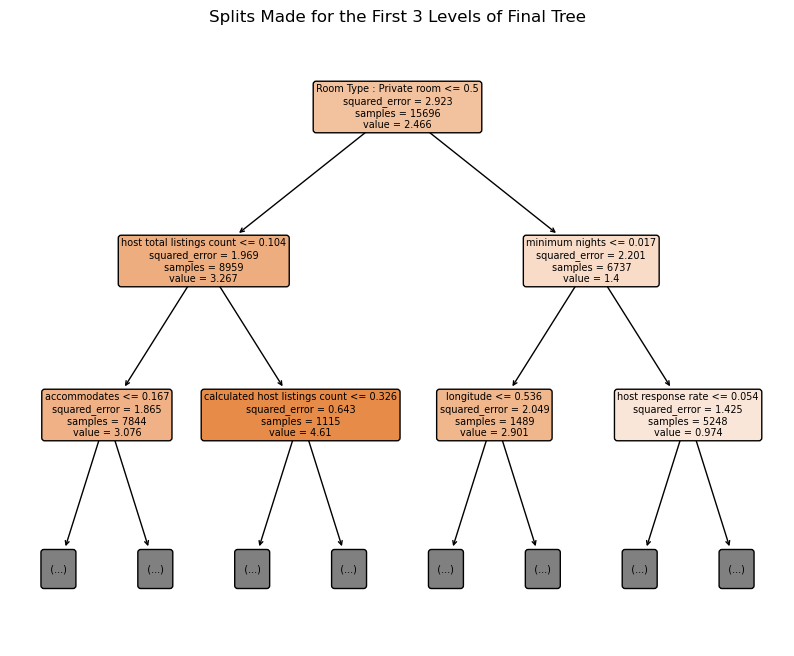

In [30]:
# take a look at the splits made on the first few levels of the final tree
plt.figure(figsize=(10, 8))
plot_tree(model1, feature_names=model1_train.columns, filled=True, rounded=True, max_depth=2, fontsize=7)
plt.title("Splits Made for the First 3 Levels of Final Tree")
plt.show()

### Feature Importance

In [31]:
# compute Gini and Permutation importance for the final tree
model1_importance = pd.DataFrame({"Feature" : model1_train.columns, 
                                  "Gini Importance" : model1.feature_importances_, 
                                  "Permutation Importance" : permutation_importance(model1, model1_train, training_labels, scoring=rounded_rmse_scorer)["importances_mean"]
                                  })

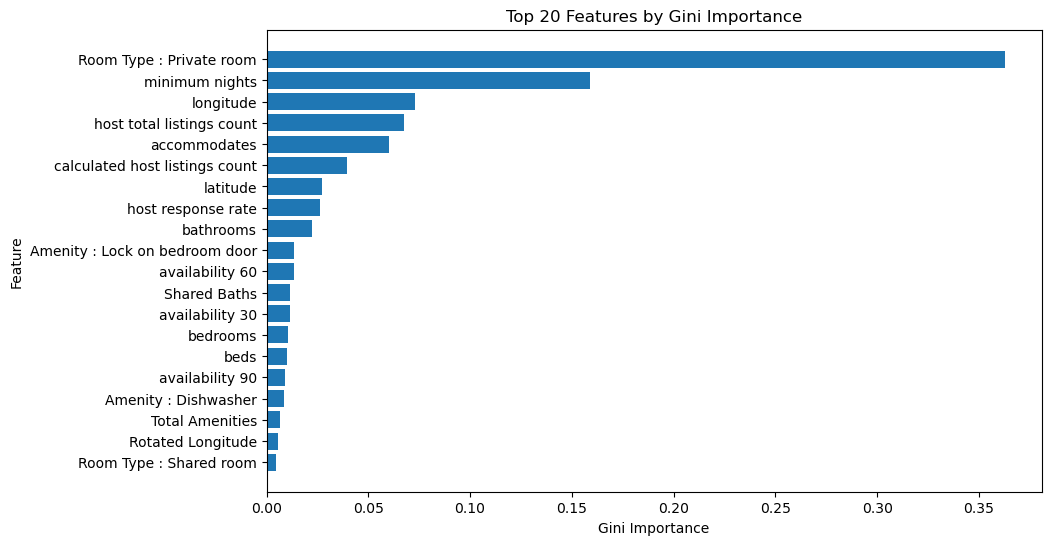

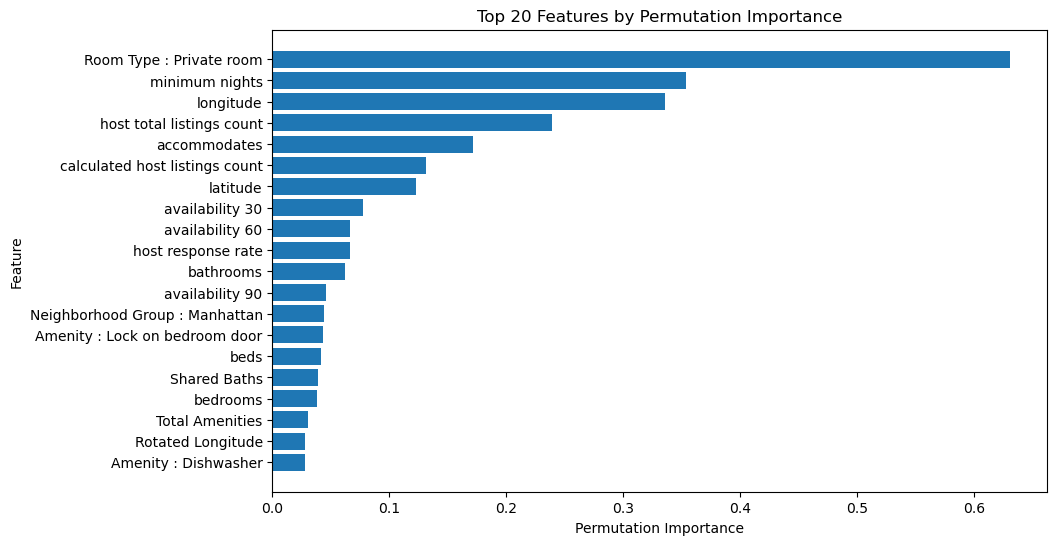

In [49]:
# get most important features according to both metrics and plot them
top_gini = model1_importance.nlargest(20, "Gini Importance")
top_permutation = model1_importance.nlargest(20, "Permutation Importance")

plt.figure(figsize=(10, 6))
plt.barh(top_gini["Feature"], top_gini["Gini Importance"], align='center')
plt.gca().invert_yaxis() 
plt.title("Top 20 Features by Gini Importance")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(top_permutation["Feature"], top_permutation["Permutation Importance"], align='center')
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Permutation Importance")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.show()

By both Gini Importance (the amount of explained variability by each feature in the tree) and Permutation Importance (the reduction in performance when randomly scrambling each feature), we see that Private Room is the most important feature. Based on the first level of the tree visualized above, it seems that private rooms are less expensive than those that do not have that label (the majority of which are "Entire home/apt"). Minimum nights is also an important feature, and when examining the same tree structure, it seems that a lower minimum means more expensive (likely a vacation rental vs. finding an actual place to live). The number of host listings and the availability of the Airbnb are also highly influential. 

## Model 2 : Random Forest

In [32]:
# read in the data for model 2
model2_train = pd.read_csv("data/model2_training_features.csv")
model2_test = pd.read_csv("data/model2_testing_features.csv")

### Feature Selection

In [33]:
# fit an arbitrary forest to determine feature importance for feature selection
feature_selection_model2 = RandomForestRegressor(random_state=3, 
                                                 criterion = "squared_error",
                                                 n_estimators = 200,
                                                 max_samples = 0.75,
                                                 max_features = 0.4,
                                                 max_depth = 25,
                                                 min_samples_split = 10,
                                                 min_samples_leaf = 3)

feature_selection_model2.fit(model2_train, training_labels)

RandomForestRegressor(max_depth=25, max_features=0.4, max_samples=0.75,
                      min_samples_leaf=3, min_samples_split=10,
                      n_estimators=200, random_state=3)

In [34]:
# compute Gini Importance for feature selection
feature_selection_importance2 = pd.DataFrame({"Feature" : model2_train.columns, 
                                              "Gini Importance" : feature_selection_model2.feature_importances_})

In [35]:
# take the top 200 features and create a new dataset
top_gini = feature_selection_importance2.nlargest(200, "Gini Importance")

model2_train_selected_features = model2_train[[col for col in model2_train.columns if col in top_gini["Feature"].tolist()]]
model2_test_selected_features = model2_test[[col for col in model2_train.columns if col in top_gini["Feature"].tolist()]]

### Hyperparameter Tuning

In [36]:
# choose hyperparameter ranges
param_distributions = {
    'max_samples' : uniform(0.5, 0.49), 
    'max_features' : uniform(0.25, 0.5), 
    'max_depth': range(15, 35),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 5)
}
# run Random Search CV for 25 iterations (with 5 folds)
hyperparameter_tuning = RandomizedSearchCV(RandomForestRegressor(random_state=3, criterion="squared_error", n_estimators=200),
                                           scoring = rounded_rmse_scorer,
                                           param_distributions = param_distributions, 
                                           n_iter = 25,
                                           cv = 5,
                                           n_jobs=-1,
                                           random_state=3)


search2 = hyperparameter_tuning.fit(model2_train_selected_features, training_labels)
search2.best_params_

{'max_depth': 34,
 'max_features': 0.7069876335029689,
 'max_samples': 0.8104961262559116,
 'min_samples_leaf': 1,
 'min_samples_split': 7}

In [37]:
# best CV score 
search2.best_score_

-0.7866467251630261

### Refitting w/ Best Parameters and Predicting Test Set

In [38]:
# refit on entire dataset with best hyper-parameter set
model2 = RandomForestRegressor(random_state=3, 
                               criterion = "squared_error",
                               n_estimators =  200,
                               max_samples = search2.best_params_["max_samples"],
                               max_features = search2.best_params_["max_features"],
                               max_depth = search2.best_params_["max_depth"],
                               min_samples_split = search2.best_params_["min_samples_split"],
                               min_samples_leaf = search2.best_params_["min_samples_leaf"])

model2.fit(model2_train_selected_features, training_labels)
# make predictions and round
model2_test_preds = np.round(model2.predict(model2_test_selected_features))

In [39]:
# Write out predictions
pd.DataFrame(
    {
        "id" : testing_ids,
        "price" : model2_test_preds
    }).to_csv("data/model2_predictions_post_feature_selection.csv", index=False)

In [46]:
# Examining how max depth impacts the performance of the forest (using all other hyper-parameters from the best combo)
param_distributions = {
    'max_depth': range(20, 40),
}

hyperparameter_tuning = GridSearchCV(RandomForestRegressor(random_state=3, 
                                                                 criterion="squared_error", 
                                                                 n_estimators=200,
                                                                 max_features = 0.7069876335029689,
                                                                 max_samples = 0.8104961262559116,
                                                                 min_samples_leaf = 1,
                                                                 min_samples_split = 7),
                                           scoring = rounded_rmse_scorer,
                                           param_grid = param_distributions, 
                                           cv = 5,
                                           n_jobs=-1)

search2pt1 = hyperparameter_tuning.fit(model2_train_selected_features, training_labels)

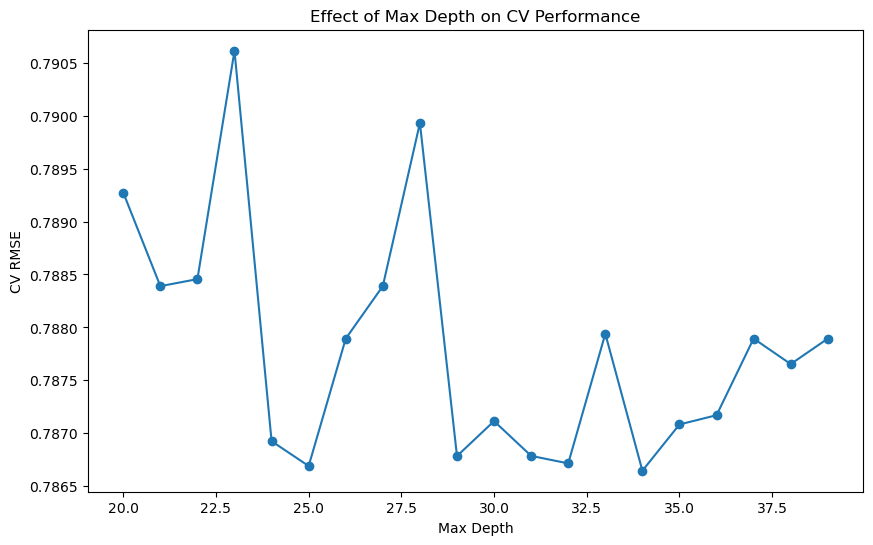

In [47]:
depth_results = pd.DataFrame(search2pt1.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(depth_results['param_max_depth'], -depth_results['mean_test_score'], marker='o')
plt.xlabel('Max Depth')
plt.ylabel('CV RMSE')
plt.title('Effect of Max Depth on CV Performance')
plt.show()

This is not a monotonic relationship, which emphasizes the importance of a hands-off random search approach to tuning, where you run enough iterations to hopefully explore all local minima before you start greedily narrowing the search window. The algorithms seems to perform best on this data with max depth between 30 and 35.

### Feature Importance

In [40]:
# take a look at Gini feature importance (permutation takes too long for 200 features and Random Forest)
model2_importance = pd.DataFrame({"Feature" : model2_train_selected_features.columns, 
                                  "Gini Importance" : model2.feature_importances_})

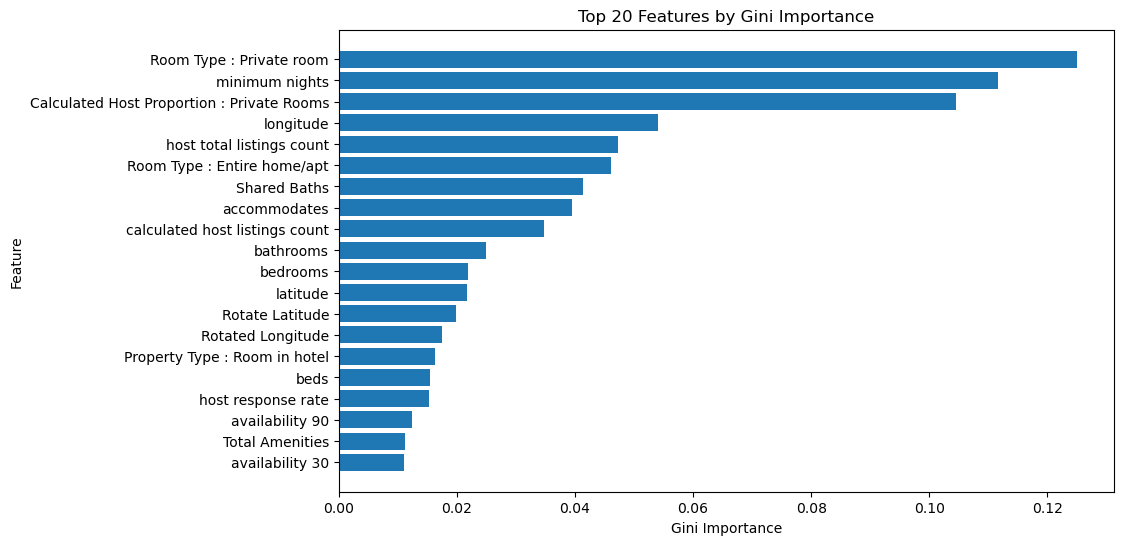

In [50]:
# Top 15 features by feature importance 
top_gini = model2_importance.nlargest(20, "Gini Importance")

plt.figure(figsize=(10, 6))
plt.barh(top_gini["Feature"], top_gini["Gini Importance"], align='center')
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Gini Importance")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.show()

The important features largely remain similar to what they were for the individual tree. One thing to note is that the actual Gini importance values themselves are more evenly distributed amongst the top 20 features than they were for the single tree. This is evidence of the Random Forest approach, relying on different features for different trees. 

## Model 3 : XGBoost

In [48]:
# read in data
model3_train = pd.read_csv("data/model3_training_features.csv")
model3_test = pd.read_csv("data/model3_testing_features.csv")

In [57]:
# set hyper-parameter ranges
param_distributions = {
    'n_estimators' : range(500, 700),
    'learning_rate' : uniform(0.05, 0.02),
    'max_depth' : range(6, 10),
    'subsample' : uniform(0.7, 0.29),
    'colsample_bytree' : uniform(0.7,0.29),
    'reg_lambda' : uniform(0.05, 0.5),
    'reg_alpha' : uniform(0.05, 0.5),
}
# Random Search for 30 iterations with 5-fold CV
hyperparameter_tuning = RandomizedSearchCV(xgb.XGBRegressor(random_state=3, objective="reg:squarederror"),
                                           scoring = rounded_rmse_scorer,
                                           param_distributions = param_distributions, 
                                           n_iter = 30,
                                           cv = 5,
                                           #verbose=3,
                                           random_state=3)


search3 = hyperparameter_tuning.fit(model3_train, training_labels)
# print best parameters
search3.best_params_

{'colsample_bytree': 0.7117829137302967,
 'learning_rate': 0.05495776594452072,
 'max_depth': 8,
 'n_estimators': 648,
 'reg_alpha': 0.06493810543928348,
 'reg_lambda': 0.27841661219735553,
 'subsample': 0.8882517738082806}

In [58]:
search3.best_score_

-0.7387936916030692

In [59]:
# refit with best parameters
model3 = xgb.XGBRegressor(random_state=3, objective="reg:squarederror",
                          n_estimators =  search3.best_params_["n_estimators"],
                          learning_rate = search3.best_params_["learning_rate"],
                          max_depth = search3.best_params_["max_depth"],
                          subsample = search3.best_params_["subsample"],
                          colsample_bytree = search3.best_params_["colsample_bytree"],
                         reg_alpha  = search3.best_params_["reg_alpha"],
                         reg_lambda = search3.best_params_["reg_lambda"])
                               
# make predictions on the test set and round
model3.fit(model3_train, training_labels)
model3_test_preds = np.round(model3.predict(model3_test))

In [60]:
# write out predictions
pd.DataFrame(
    {
        "id" : testing_ids,
        "price" : model3_test_preds
    }).to_csv("data/model3_predictions.csv", index=False)